In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re
import cdtime
import glob


pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def rescale (F, factor=None, myunits=None, offset=None):
    name = F.id
    if ((not offset is None) & (not factor is None)):
        print("rescale cannot set both offset and factor")
        # if you want to then exit the program
        import sys
        sys.exit(1)
    if not offset is None:
        F = F - offset;
    if not factor is None:
        F = F*Factor
    if not myunits is None:
        F.units = myunits 
    if F.id is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if F.id is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "BURDEN2":
        F = F*1.e6
        F.units = "mg/m2"
        
    F.id = name
    return F;

# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None, time=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1, time=time)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
import matplotlib.path as mpath
def setup3 ():
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    sbnd = 60.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(figsize=(4, 8)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[10, 1]) 

    ax0 = plt.subplot(gs[0],projection=ccrs.NorthPolarStereo())
    ax0.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax0.set_boundary(circle, transform=ax0.transAxes)
#   ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    
    ax1 = plt.subplot(gs[2],projection=ccrs.NorthPolarStereo())
    ax1.set_global() # make axis consistent with projection limits
    ax1.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.NorthPolarStereo())
    ax2.set_global() # make axis consistent with projection limits
    ax2.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Orthographic(0, 90))
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, fig=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
#    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
#    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
#   print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
#    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, fig, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


In [4]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

#vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
#vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

#vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
vlist.append(vsets("TMQ", "TMQ","TMQ"))
#vlist.append(vsets("SST", "SST","SST"))
#vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
#vlist.append(vsets("FLNT", "FLNT","FLNT"))
#vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
#vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
#vlist.append(vsets('LWCF', 'LWCF','LWCF'))
#vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
#vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
#vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets('SWCF', 'SWCF','SWCF'))
#vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
#vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
#vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
#vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))


def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["JAN"]

In [5]:
# identify fields to be evaluated


def setupfilenames (mon):
    import fnmatch
    import os
    # model2 dataset (the experiment)
    dir2 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir2 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    files = fnmatch.filter(os.listdir(dir2), "*cam.h1.2009-"+mon+"*00.nc")
#    print "files", files
    
    # the "reference" dataset
    dir1 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir1 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    f1 = "yotc_f02_pdil_sat_"+mon+".cam.h0.2009-"+mon+".nc"

    
#   print "all",files
#    files = files

    #files = {files[0]} # select only the first file for debugging   
    for f2 in files:
        #print "f2 is ", f2
        print(f2)
    
    return dir1, f1, dir2, files



In [6]:

def processtime(vname, dir1, f1, dir2, files):
    
    print "processing time average"
# model1 dataset (the reference)

    title1 = "MONAVG"
    ltit1 = title1  
    rtit1 = ""
    jname1 = dir1+f1
    print "jname1 ", jname1    

    g1 = cdms2.open(jname1);
    print "reference dataset is jname1", jname1  

#    varlist2 = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist2
#    dims2 = g2.listdimension();
#    print "g2 dims", dims2    
    

    T1 = getfld(g1,vname,time=slice(0,1)) # first time slice
    T1 = rescale(T1);
#    print "T1 shape", T1.shape

    print "processing timeslice from dir2 ", dir2
    print "xxx1", files
    for f2 in files:

        # model2 dataset (the experiment) 
        jname2 = dir2+f2
        g2 = cdms2.open(jname2);
        print "jname2", jname2
        varlist = g2.listvariables();
    #   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
    #    print "g2 varlist", varlist
        dims = g2.listdimension();
    #   print "j2 dims"
        dims = g2.listdimension();
        tindex = dims.index('time')
    #   print "tindex", tindex
        diminfo = g2[dims[tindex]].attributes
        #xx = g2[dims[tindex]].asComponentTime()
        #print "xx",xx
    #    print "diminfo", diminfo
        timeunits = diminfo['units']
        #print "timeunits", timeunits
        times = g2[dims[tindex]][:]
        #print "times", times
        starttime = g2[dims[tindex]][0]
        #print "starttime", starttime

    #if 1 == 1:
        thistime = times[0]
    #for thistime in times:
        #print "thistime", thistime

        #T2 = getfld(g2,vname,time=slice(0,1))
        T2 = getfld(g2,vname,time=thistime)
        T2 = rescale(T2)
        rt = cdtime.reltime(thistime, timeunits)
        #print "rt", rt
        ct = rt.tocomp()
        #help(ct)
        #print "ct", ct

        title2 = "{:.2f}".format(thistime)
        title2 = ct
        ltit2 = title2
        rtit2 = ""

    # if 1 == 1:
        sbnd = 60.
        T1 = T1.subRegion(latitude=(sbnd,90.))
        T2 = T2.subRegion(latitude=(sbnd,90.))


    #    T2 = getfld(g2,"QV")
    #    DELP = getfld(g2,'DELP')
    #    T2V = T2*DELP/9.806

    #    T2V = cdutil.averager(T2V,axis="t",weights='unweighted')
    #    T2V = cdutil.averager(T2V,axis="z",weights='equal', action='sum')
    #    print "range", T2V.min(), T2V.max()
    #    pltframe(T2V, lons, lats, ax3[0], cx3[0])    
    #    T2 = T2V    

        if plottype == "DIFF":
            DT = T2 - T1
        else:
            DT = T2/T1

        DT.id = T1.id

        ctstring = "{:04d}_{:02d}_{:02d}h{:02d}".format(ct.year, ct.month, ct.day, ct.hour)
        if plottype == "DIFF":
            pltname = "workdir/"+vname+"_"+ctstring+"_D.pdf"
        else:
            pltname = "workdir/"+vname+"_"+ctstring+"_R.pdf"

        lons = T1.getLongitude()
        lats = T1.getLatitude()
    #   pltframe(T1, lons, lats, ax3[1], cx3[1])# , 
        #plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

        print "figure being saved to ", pltname
        fig, ax3, cx3 = setup3()
    #    pltframe(DT, lons, lats, ax3[2], cx3[2]) #, 
        #  plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})    

        cmap = plt.cm.viridis

    #    print "plotting MERRA2"
    #    print TP0.info()
        dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
        clevs = pjr.findNiceContours(dtrng)
        if T1.id == "BURDEN2":
            clevs = np.array([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])*0.1

        pltframe(T2, lons, lats, fig, ax3[0], cx3[0], 
                 plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    #    print "plotting E3SM"
        pltframe(T1, lons, lats, fig, ax3[1], cx3[1], 
                 plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

        cmap = pjr.diverge_map()
    #   cmap = plt.cm.viridis


    #    print "T1.info", T1.info()
    #    print "DT info", DT.info()

    #    print "DT.id", DT.id
        if plottype == "DIFF":
            dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
            if DT.id == 'LWCF':
                dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
            if DT.id == 'SWCF':
                dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
            if DT.id == 'TS':
                dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
            if DT.id == 'TGCLDIWP':
                dlevs = [-5.,-2.,-1.,1.,2.,5.]
            if DT.id == 'FSNT':
                dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
            if DT.id == 'BURDEN1':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])
            if DT.id == 'BURDEN2':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])

        else:
            # ratio plots
            dtrng = np.array([0.,DT.max()])
            print "dtrng", dtrng
            dtrng = dtrng*0.5
            dlevs = pjr.findNiceContours(dtrng,nlevs=12,rmClev=0, sym=True)
            print "dlevs1", dlevs
            dlevs = (dlevs + dlevs.max())
            if DT.id == 'BURDEN1':
                dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
            if DT.id == 'BURDEN2':
                #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
                dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
            if DT.id == 'TMQ':
                dlevs = np.array([0.,0.2,0.4,0.6,0.8,1.2,1.5,2.,3.0,4.0])
                print "final ratio plot dlevs", dlevs

        dtitle = ""
        rtitD = vname
        pltframe(DT, lons, lats, fig, ax3[2], cx3[2], 
                 plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        x = plt.show()

        print "done with time "+ctstring+"\n\n\n"
      
    print "processtime complete"
    return



yotc_f02_pdil_sat_02.cam.h1.2009-02-14-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-09-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-04-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-07-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-26-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-22-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-21-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-17-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-10-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-27-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-11-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-15-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-19-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-24-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-01-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-20-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-06-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-28-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-13-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-12-21600.nc
yotc_f02_pdil_sat_02.cam.h1.2009-02-08-2

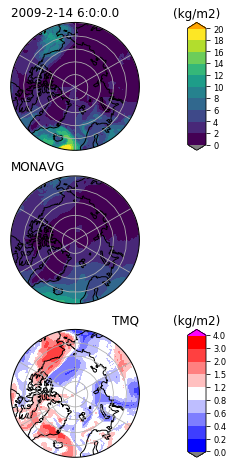

done with time 2009_02_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-09-21600.nc
figure being saved to  workdir/TMQ_2009_02_09h06_R.pdf
data range 0.41428477 14.496117
data range 0.764992 12.871137
dtrng [0.         2.67646861]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.18993406 2.6764686


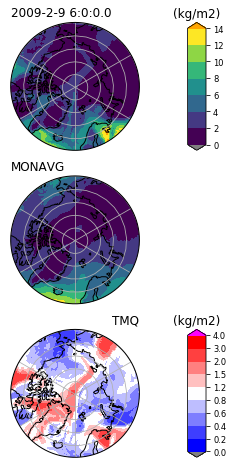

done with time 2009_02_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-04-21600.nc
figure being saved to  workdir/TMQ_2009_02_04h06_R.pdf
data range 0.42348102 14.523378
data range 0.764992 12.871137
dtrng [0.         3.79843521]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19617172 3.7984352


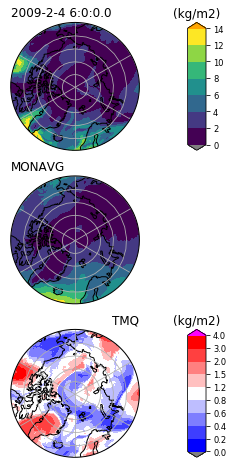

done with time 2009_02_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-07-21600.nc
figure being saved to  workdir/TMQ_2009_02_07h06_R.pdf
data range 0.62737745 15.387291
data range 0.764992 12.871137
dtrng [0.        2.4711113]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20793717 2.4711113


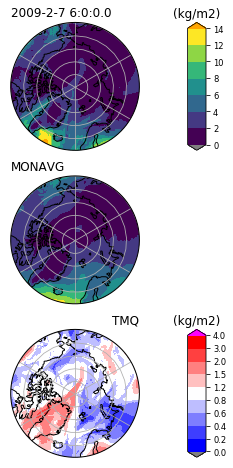

done with time 2009_02_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-26-21600.nc
figure being saved to  workdir/TMQ_2009_02_26h06_R.pdf
data range 0.3837899 16.356089
data range 0.764992 12.871137
dtrng [0.         2.52228284]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.13259864 2.5222828


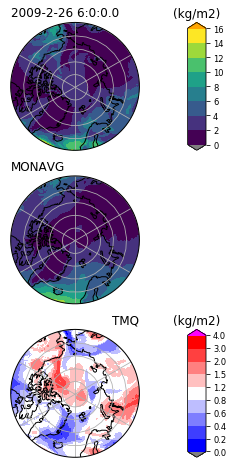

done with time 2009_02_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-22-21600.nc
figure being saved to  workdir/TMQ_2009_02_22h06_R.pdf
data range 0.19923063 22.404245
data range 0.764992 12.871137
dtrng [0.         4.08011293]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16255774 4.080113


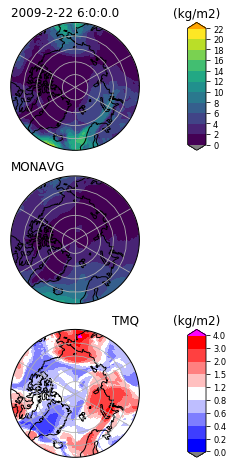

done with time 2009_02_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-21-21600.nc
figure being saved to  workdir/TMQ_2009_02_21h06_R.pdf
data range 0.19833718 25.858006
data range 0.764992 12.871137
dtrng [0.         3.09559584]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.104645744 3.0955958


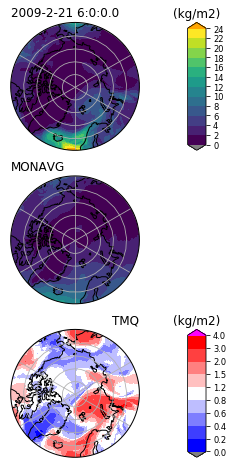

done with time 2009_02_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-17-21600.nc
figure being saved to  workdir/TMQ_2009_02_17h06_R.pdf
data range 0.34375596 20.022726
data range 0.764992 12.871137
dtrng [0.         3.76243067]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.15280183 3.7624307


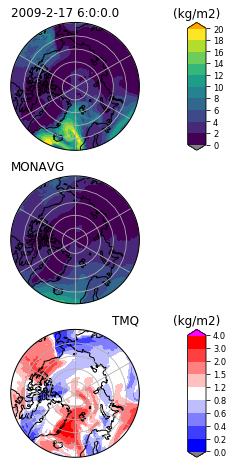

done with time 2009_02_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-10-21600.nc
figure being saved to  workdir/TMQ_2009_02_10h06_R.pdf
data range 0.4398256 14.162927
data range 0.764992 12.871137
dtrng [0.         3.01709962]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.15741624 3.0170996


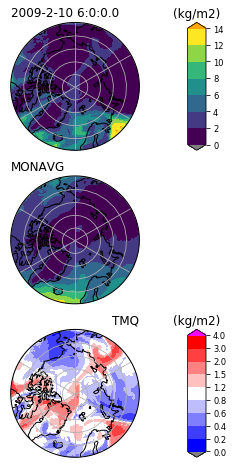

done with time 2009_02_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-27-21600.nc
figure being saved to  workdir/TMQ_2009_02_27h06_R.pdf
data range 0.4027538 17.307966
data range 0.764992 12.871137
dtrng [0.         3.87918139]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.13164248 3.8791814


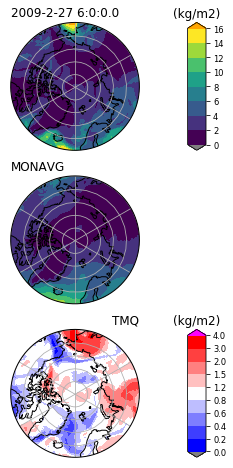

done with time 2009_02_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-11-21600.nc
figure being saved to  workdir/TMQ_2009_02_11h06_R.pdf
data range 0.4745312 16.156553
data range 0.764992 12.871137
dtrng [0.         2.66978621]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.25134408 2.6697862


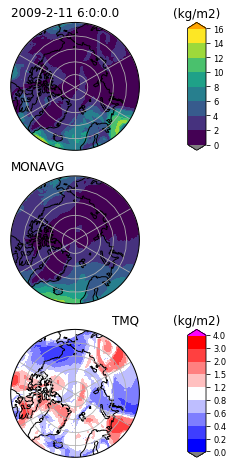

done with time 2009_02_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-15-21600.nc
figure being saved to  workdir/TMQ_2009_02_15h06_R.pdf
data range 0.5199218 23.280777
data range 0.764992 12.871137
dtrng [0.         2.72436404]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.28996685 2.724364


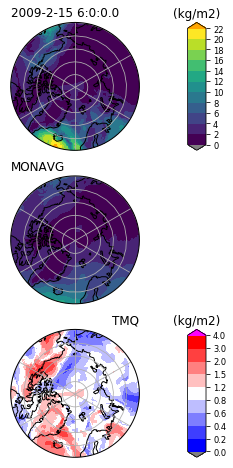

done with time 2009_02_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-19-21600.nc
figure being saved to  workdir/TMQ_2009_02_19h06_R.pdf
data range 0.35155866 20.487883
data range 0.764992 12.871137
dtrng [0.         4.54257965]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.17889185 4.5425797


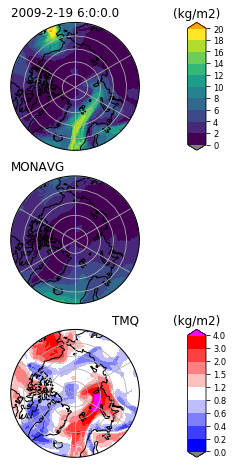

done with time 2009_02_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-24-21600.nc
figure being saved to  workdir/TMQ_2009_02_24h06_R.pdf
data range 0.35651928 19.226448
data range 0.764992 12.871137
dtrng [0.         3.74676776]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.24569385 3.7467678


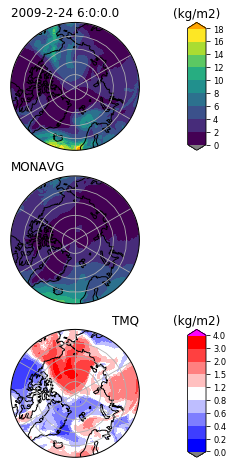

done with time 2009_02_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-01-21600.nc
figure being saved to  workdir/TMQ_2009_02_01h06_R.pdf
data range 0.3286011 18.324451
data range 0.764992 12.871137
dtrng [0.         3.43545318]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.2295355 3.4354532


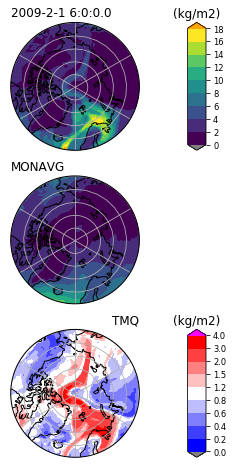

done with time 2009_02_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-20-21600.nc
figure being saved to  workdir/TMQ_2009_02_20h06_R.pdf
data range 0.28982753 25.956308
data range 0.764992 12.871137
dtrng [0.         3.89742661]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.22694424 3.8974266


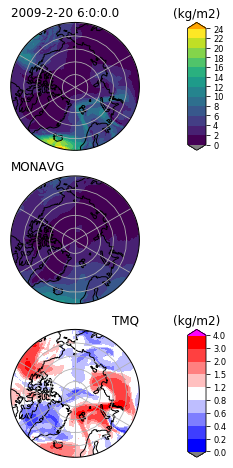

done with time 2009_02_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-06-21600.nc
figure being saved to  workdir/TMQ_2009_02_06h06_R.pdf
data range 0.5039542 13.171528
data range 0.764992 12.871137
dtrng [0.         2.89974618]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16174728 2.8997462


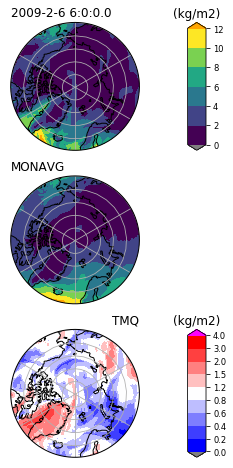

done with time 2009_02_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-28-21600.nc
figure being saved to  workdir/TMQ_2009_02_28h06_R.pdf
data range 0.42429313 19.051271
data range 0.764992 12.871137
dtrng [0.         2.86522532]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.22055818 2.8652253


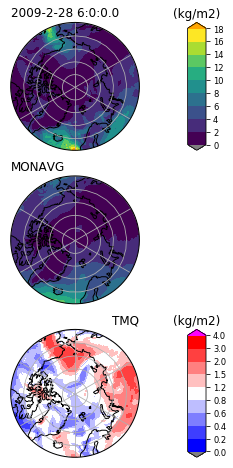

done with time 2009_02_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-13-21600.nc
figure being saved to  workdir/TMQ_2009_02_13h06_R.pdf
data range 0.42640844 21.364494
data range 0.764992 12.871137
dtrng [0.         2.84023046]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.21819237 2.8402305


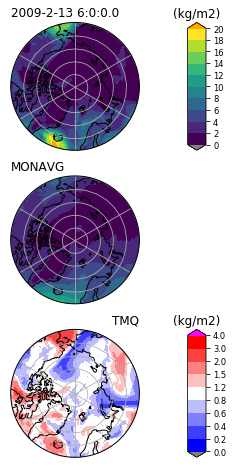

done with time 2009_02_13h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-12-21600.nc
figure being saved to  workdir/TMQ_2009_02_12h06_R.pdf
data range 0.520616 22.516056
data range 0.764992 12.871137
dtrng [0.        2.2874496]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.23338422 2.2874496


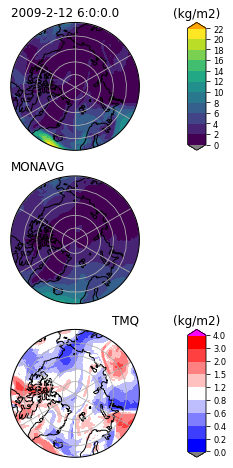

done with time 2009_02_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-08-21600.nc
figure being saved to  workdir/TMQ_2009_02_08h06_R.pdf
data range 0.4994323 16.550112
data range 0.764992 12.871137
dtrng [0.         2.51922131]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20505705 2.5192213


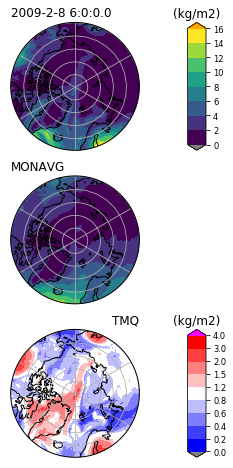

done with time 2009_02_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-25-21600.nc
figure being saved to  workdir/TMQ_2009_02_25h06_R.pdf
data range 0.31355444 15.76201
data range 0.764992 12.871137
dtrng [0.         3.09878612]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.2223936 3.098786


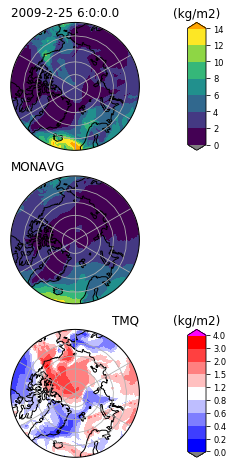

done with time 2009_02_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-03-21600.nc
figure being saved to  workdir/TMQ_2009_02_03h06_R.pdf
data range 0.2727118 17.621094
data range 0.764992 12.871137
dtrng [0.        2.3606174]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.18939383 2.3606174


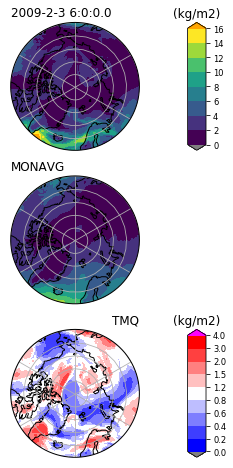

done with time 2009_02_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-05-21600.nc
figure being saved to  workdir/TMQ_2009_02_05h06_R.pdf
data range 0.45689887 14.797362
data range 0.764992 12.871137
dtrng [0.         2.97065353]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.104251064 2.9706535


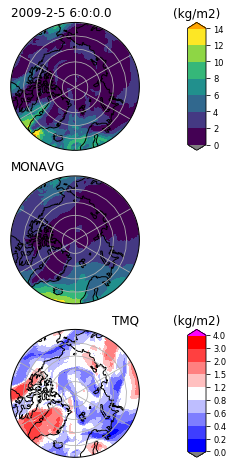

done with time 2009_02_05h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-18-21600.nc
figure being saved to  workdir/TMQ_2009_02_18h06_R.pdf
data range 0.17137086 20.89337
data range 0.764992 12.871137
dtrng [0.         4.57587004]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.07465133 4.57587


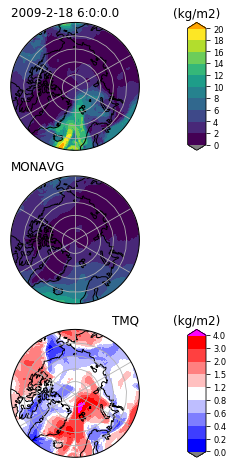

done with time 2009_02_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-23-21600.nc
figure being saved to  workdir/TMQ_2009_02_23h06_R.pdf
data range 0.2750756 22.87533
data range 0.764992 12.871137
dtrng [0.         5.38966036]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.22750378 5.3896604


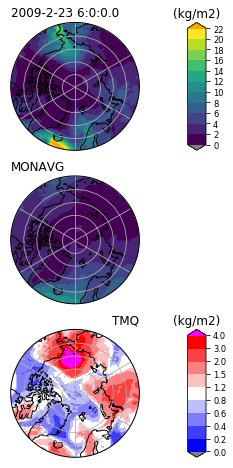

done with time 2009_02_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-16-21600.nc
figure being saved to  workdir/TMQ_2009_02_16h06_R.pdf
data range 0.45395538 25.644123
data range 0.764992 12.871137
dtrng [0.         3.10105467]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16613244 3.1010547


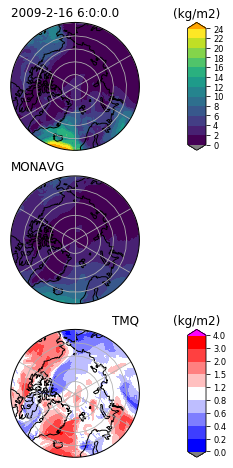

done with time 2009_02_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-02-21600.nc
figure being saved to  workdir/TMQ_2009_02_02h06_R.pdf
data range 0.28272116 14.526479
data range 0.764992 12.871137
dtrng [0.         2.64867663]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19870143 2.6486766


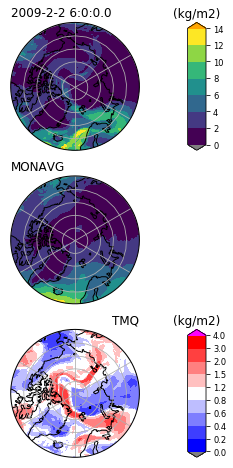

done with time 2009_02_02h06



yotc_f02_pdil_sat_03.cam.h1.2009-03-17-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-15-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-16-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-21-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-31-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-02-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-04-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-11-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-22-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-26-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-07-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-23-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-19-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-28-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-01-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-12-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-18-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-20-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-24-21600.nc
yotc_f02_pdil_sat_03.cam.h1.2009-03-27-21600.nc
yotc_f02

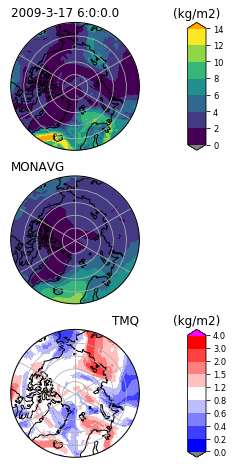

done with time 2009_03_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-15-21600.nc
figure being saved to  workdir/TMQ_2009_03_15h06_R.pdf
data range 0.31061172 19.044575
data range 0.6774402 11.991275
dtrng [0.         2.41285825]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.14784238 2.4128582


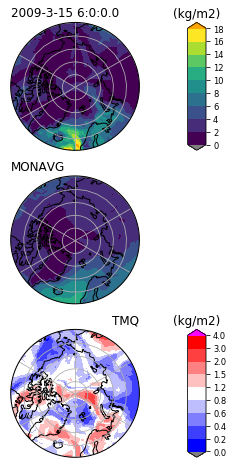

done with time 2009_03_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-16-21600.nc
figure being saved to  workdir/TMQ_2009_03_16h06_R.pdf
data range 0.40421572 18.238543
data range 0.6774402 11.991275
dtrng [0.         2.92413712]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16574895 2.924137


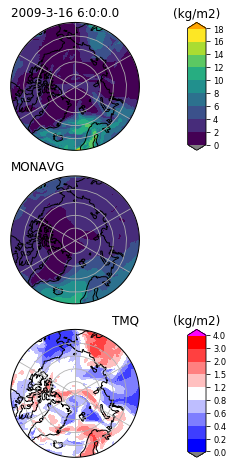

done with time 2009_03_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-21-21600.nc
figure being saved to  workdir/TMQ_2009_03_21h06_R.pdf
data range 0.48463914 19.466352
data range 0.6774402 11.991275
dtrng [0.         4.98075104]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.25837946 4.980751


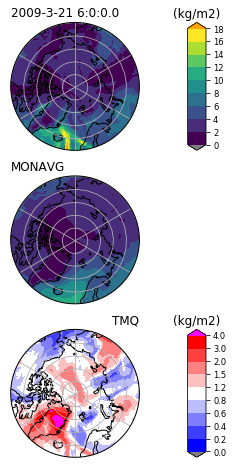

done with time 2009_03_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-31-21600.nc
figure being saved to  workdir/TMQ_2009_03_31h06_R.pdf
data range 0.33632442 22.100374
data range 0.6774402 11.991275
dtrng [0.         3.84809566]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19494778 3.8480957


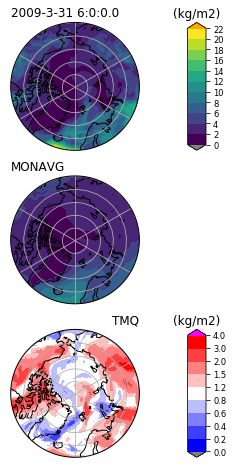

done with time 2009_03_31h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-02-21600.nc
figure being saved to  workdir/TMQ_2009_03_02h06_R.pdf
data range 0.23503855 16.251167
data range 0.6774402 11.991275
dtrng [0.         3.15888381]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.13381127 3.1588838


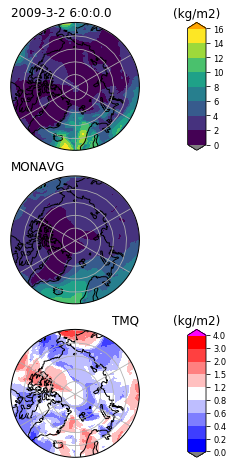

done with time 2009_03_02h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-04-21600.nc
figure being saved to  workdir/TMQ_2009_03_04h06_R.pdf
data range 0.305009 15.236587
data range 0.6774402 11.991275
dtrng [0.         3.52782083]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.24150473 3.5278208


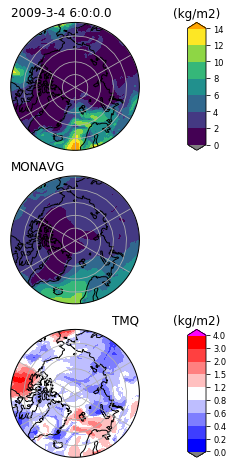

done with time 2009_03_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-11-21600.nc
figure being saved to  workdir/TMQ_2009_03_11h06_R.pdf
data range 0.52064836 22.603874
data range 0.6774402 11.991275
dtrng [0.         2.79070497]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.22928761 2.790705


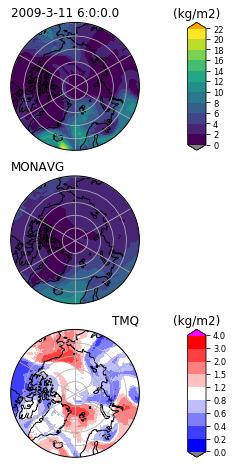

done with time 2009_03_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-22-21600.nc
figure being saved to  workdir/TMQ_2009_03_22h06_R.pdf
data range 0.44814467 14.398197
data range 0.6774402 11.991275
dtrng [0.         4.33151436]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.23085122 4.3315144


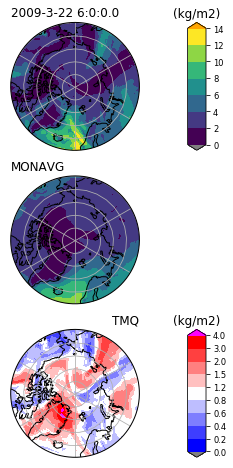

done with time 2009_03_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-26-21600.nc
figure being saved to  workdir/TMQ_2009_03_26h06_R.pdf
data range 0.40605325 17.340282
data range 0.6774402 11.991275
dtrng [0.         2.97980952]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.23650205 2.9798095


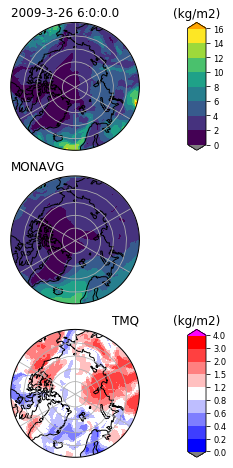

done with time 2009_03_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-07-21600.nc
figure being saved to  workdir/TMQ_2009_03_07h06_R.pdf
data range 0.34893167 14.208446
data range 0.6774402 11.991275
dtrng [0.         2.43893933]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.17419772 2.4389393


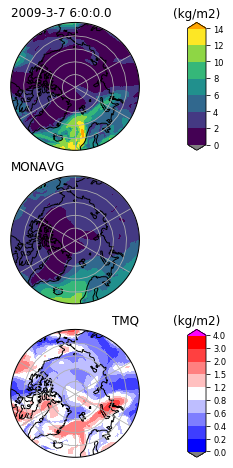

done with time 2009_03_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-23-21600.nc
figure being saved to  workdir/TMQ_2009_03_23h06_R.pdf
data range 0.51782453 12.523035
data range 0.6774402 11.991275
dtrng [0.         3.12120342]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.21593393 3.1212034


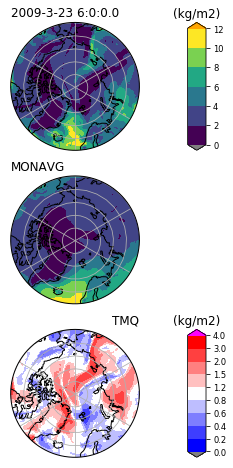

done with time 2009_03_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-19-21600.nc
figure being saved to  workdir/TMQ_2009_03_19h06_R.pdf
data range 0.44545844 21.061197
data range 0.6774402 11.991275
dtrng [0.         2.48292828]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19541876 2.4829283


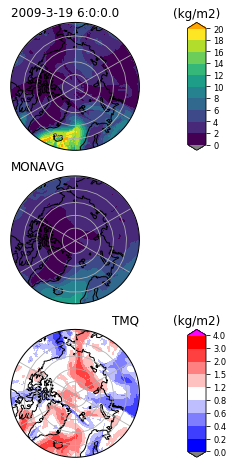

done with time 2009_03_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-28-21600.nc
figure being saved to  workdir/TMQ_2009_03_28h06_R.pdf
data range 0.34510097 16.938002
data range 0.6774402 11.991275
dtrng [0.        3.5648849]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20095886 3.564885


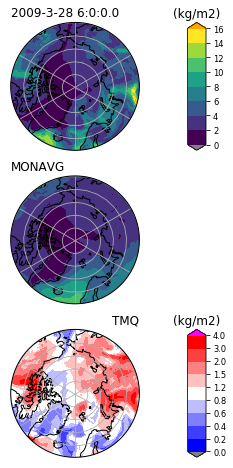

done with time 2009_03_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-01-21600.nc
figure being saved to  workdir/TMQ_2009_03_01h06_R.pdf
data range 0.29903892 16.668333
data range 0.6774402 11.991275
dtrng [0.         2.66588092]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.2057138 2.665881


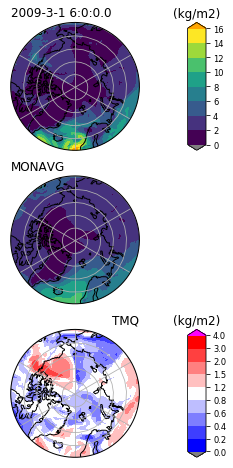

done with time 2009_03_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-12-21600.nc
figure being saved to  workdir/TMQ_2009_03_12h06_R.pdf
data range 0.46865836 15.681662
data range 0.6774402 11.991275
dtrng [0.         2.55442047]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.24480158 2.5544205


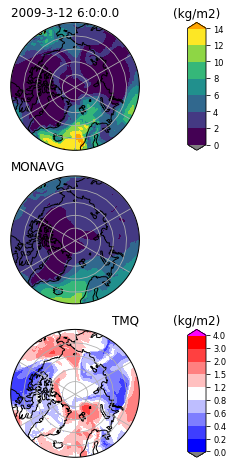

done with time 2009_03_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-18-21600.nc
figure being saved to  workdir/TMQ_2009_03_18h06_R.pdf
data range 0.4569771 21.958784
data range 0.6774402 11.991275
dtrng [0.         3.43609071]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20954661 3.4360907


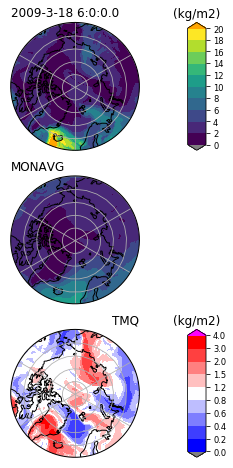

done with time 2009_03_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-20-21600.nc
figure being saved to  workdir/TMQ_2009_03_20h06_R.pdf
data range 0.44124773 22.516281
data range 0.6774402 11.991275
dtrng [0.         4.68452787]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.25045162 4.684528


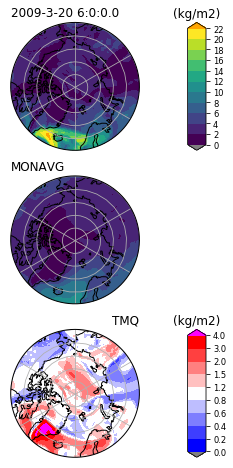

done with time 2009_03_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-24-21600.nc
figure being saved to  workdir/TMQ_2009_03_24h06_R.pdf
data range 0.49374294 14.396848
data range 0.6774402 11.991275
dtrng [0.         3.53564143]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.1733926 3.5356414


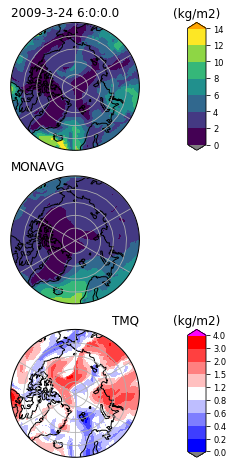

done with time 2009_03_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-27-21600.nc
figure being saved to  workdir/TMQ_2009_03_27h06_R.pdf
data range 0.37374827 16.879856
data range 0.6774402 11.991275
dtrng [0.        4.1216054]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.21868187 4.1216054


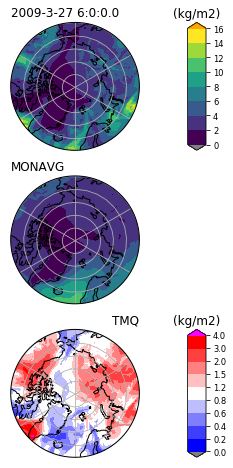

done with time 2009_03_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-09-21600.nc
figure being saved to  workdir/TMQ_2009_03_09h06_R.pdf
data range 0.43153378 15.178511
data range 0.6774402 11.991275
dtrng [0.         3.51610875]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16006441 3.5161088


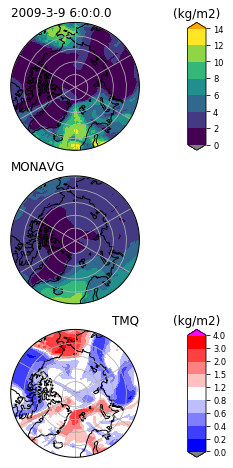

done with time 2009_03_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-10-21600.nc
figure being saved to  workdir/TMQ_2009_03_10h06_R.pdf
data range 0.40260637 13.846082
data range 0.6774402 11.991275
dtrng [0.         3.31220889]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.14794526 3.312209


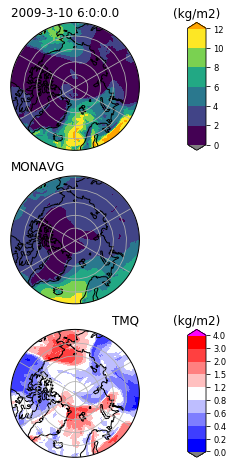

done with time 2009_03_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-25-21600.nc
figure being saved to  workdir/TMQ_2009_03_25h06_R.pdf
data range 0.3978855 12.581008
data range 0.6774402 11.991275
dtrng [0.         3.13397837]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.2555034 3.1339784


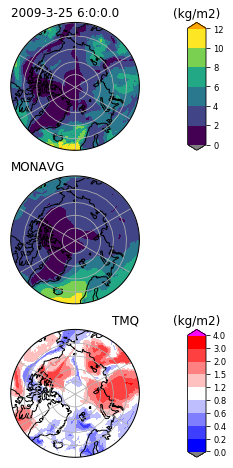

done with time 2009_03_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-06-21600.nc
figure being saved to  workdir/TMQ_2009_03_06h06_R.pdf
data range 0.3122679 15.694208
data range 0.6774402 11.991275
dtrng [0.         3.36798167]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.2359795 3.3679817


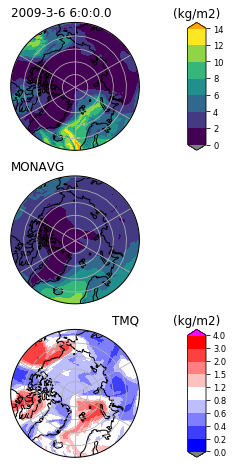

done with time 2009_03_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-13-21600.nc
figure being saved to  workdir/TMQ_2009_03_13h06_R.pdf
data range 0.44185823 14.037296
data range 0.6774402 11.991275
dtrng [0.         2.49728203]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.21223225 2.497282


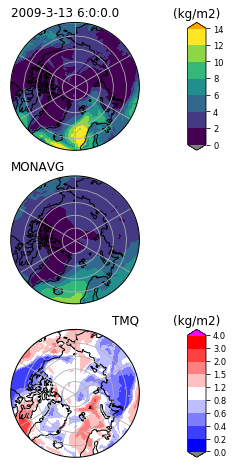

done with time 2009_03_13h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-14-21600.nc
figure being saved to  workdir/TMQ_2009_03_14h06_R.pdf
data range 0.3586117 18.936928
data range 0.6774402 11.991275
dtrng [0.         2.23880363]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19596149 2.2388036


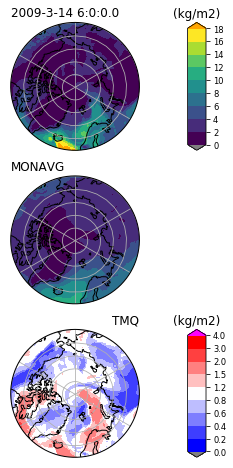

done with time 2009_03_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-30-21600.nc
figure being saved to  workdir/TMQ_2009_03_30h06_R.pdf
data range 0.2061185 14.7058735
data range 0.6774402 11.991275
dtrng [0.         3.79025435]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19227289 3.7902544


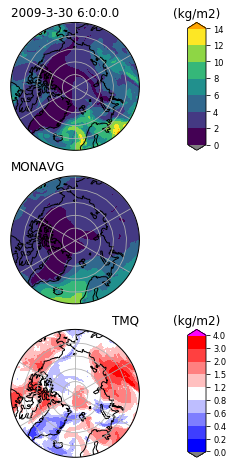

done with time 2009_03_30h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-29-21600.nc
figure being saved to  workdir/TMQ_2009_03_29h06_R.pdf
data range 0.26561537 16.183489
data range 0.6774402 11.991275
dtrng [0.         4.09149981]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.15906805 4.0915


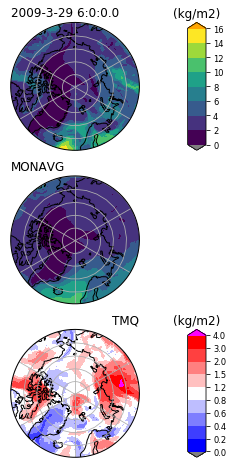

done with time 2009_03_29h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-03-21600.nc
figure being saved to  workdir/TMQ_2009_03_03h06_R.pdf
data range 0.30809325 13.22131
data range 0.6774402 11.991275
dtrng [0.         2.60319471]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.17888781 2.6031947


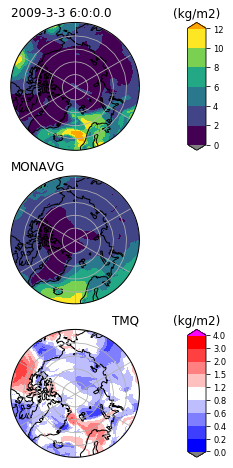

done with time 2009_03_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-08-21600.nc
figure being saved to  workdir/TMQ_2009_03_08h06_R.pdf
data range 0.3839375 16.12671
data range 0.6774402 11.991275
dtrng [0.         3.36291075]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.2027879 3.3629107


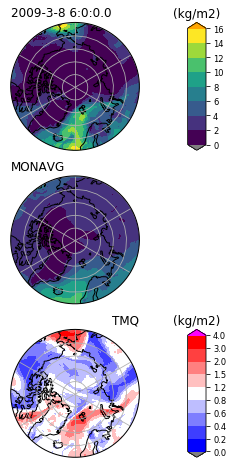

done with time 2009_03_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_03/atm/hist/yotc_f02_pdil_sat_03.cam.h1.2009-03-05-21600.nc
figure being saved to  workdir/TMQ_2009_03_05h06_R.pdf
data range 0.26612055 22.406736
data range 0.6774402 11.991275
dtrng [0.         4.33129787]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.14863963 4.331298


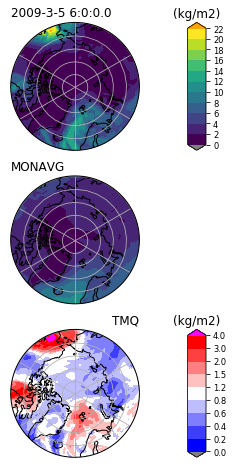

done with time 2009_03_05h06



yotc_f02_pdil_sat_04.cam.h1.2009-04-24-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-25-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-18-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-01-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-04-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-29-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-15-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-02-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-19-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-06-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-10-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-14-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-13-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-17-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-08-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-11-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-03-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-22-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-09-21600.nc
yotc_f02_pdil_sat_04.cam.h1.2009-04-05-21600.nc
yotc_f02

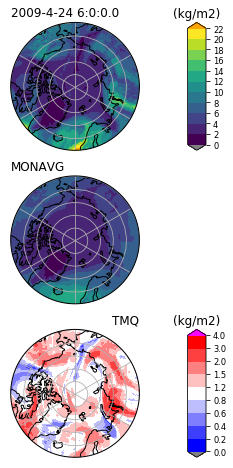

done with time 2009_04_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-25-21600.nc
figure being saved to  workdir/TMQ_2009_04_25h06_R.pdf
data range 0.5297104 19.813963
data range 0.8928696 14.075871
dtrng [0.         3.16640973]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.27768356 3.1664097


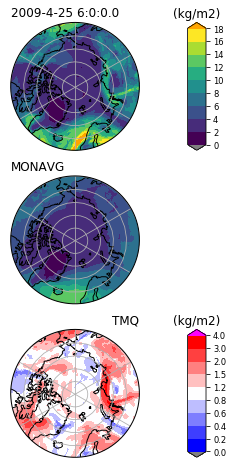

done with time 2009_04_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-18-21600.nc
figure being saved to  workdir/TMQ_2009_04_18h06_R.pdf
data range 0.18928792 19.458218
data range 0.8928696 14.075871
dtrng [0.         3.88397169]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16485715 3.8839717


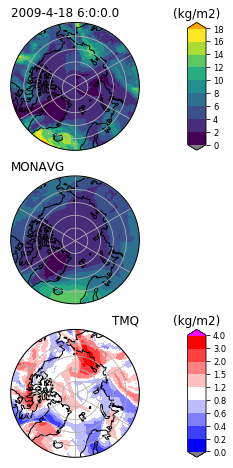

done with time 2009_04_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-01-21600.nc
figure being saved to  workdir/TMQ_2009_04_01h06_R.pdf
data range 0.2678779 22.18982
data range 0.8928696 14.075871
dtrng [0.         2.42192411]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.11879241 2.421924


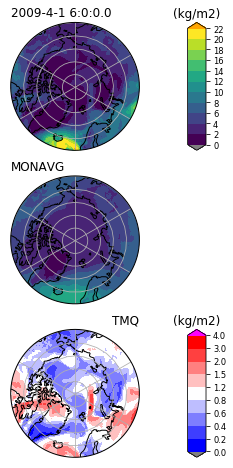

done with time 2009_04_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-04-21600.nc
figure being saved to  workdir/TMQ_2009_04_04h06_R.pdf
data range 0.52154016 21.967775
data range 0.8928696 14.075871
dtrng [0.         2.28417015]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.19929354 2.2841702


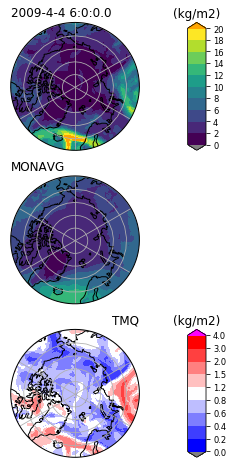

done with time 2009_04_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-29-21600.nc
figure being saved to  workdir/TMQ_2009_04_29h06_R.pdf
data range 0.8280902 23.227875
data range 0.8928696 14.075871
dtrng [0.         3.36572433]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.23578571 3.3657243


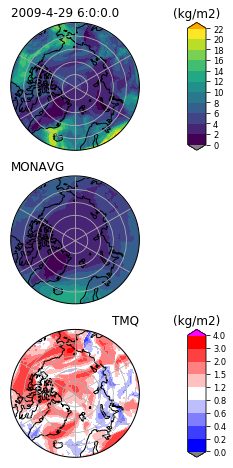

done with time 2009_04_29h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-15-21600.nc
figure being saved to  workdir/TMQ_2009_04_15h06_R.pdf
data range 0.24317046 21.157248
data range 0.8928696 14.075871
dtrng [0.         2.99931908]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.1873694 2.999319


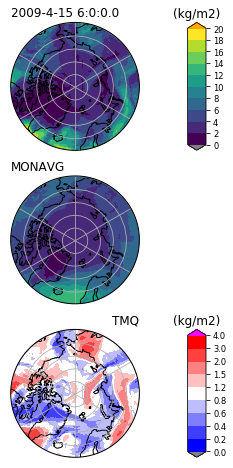

done with time 2009_04_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-02-21600.nc
figure being saved to  workdir/TMQ_2009_04_02h06_R.pdf
data range 0.28 23.160051
data range 0.8928696 14.075871
dtrng [0.        2.2909646]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.18162958 2.2909646


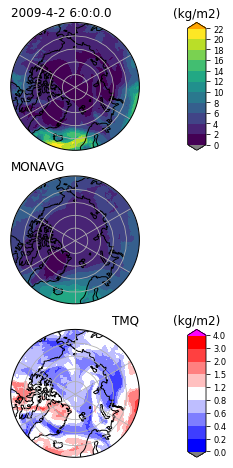

done with time 2009_04_02h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-19-21600.nc
figure being saved to  workdir/TMQ_2009_04_19h06_R.pdf
data range 0.44030777 21.208586
data range 0.8928696 14.075871
dtrng [0.         3.25107217]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.3059151 3.2510722


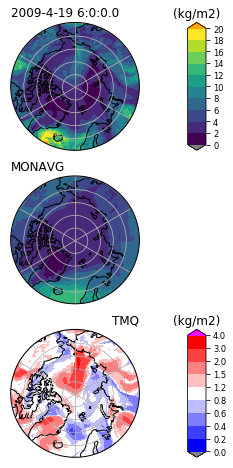

done with time 2009_04_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-06-21600.nc
figure being saved to  workdir/TMQ_2009_04_06h06_R.pdf
data range 0.37237668 17.57236
data range 0.8928696 14.075871
dtrng [0.         2.61059952]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.23013352 2.6105995


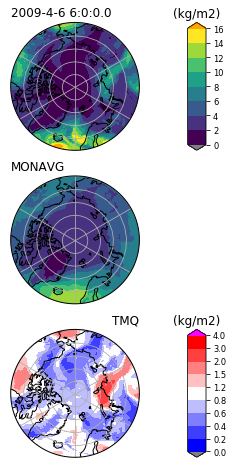

done with time 2009_04_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-10-21600.nc
figure being saved to  workdir/TMQ_2009_04_10h06_R.pdf
data range 0.20629326 23.721867
data range 0.8928696 14.075871
dtrng [0.         3.02446818]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.12062893 3.0244682


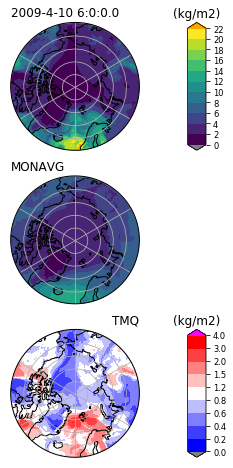

done with time 2009_04_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-14-21600.nc
figure being saved to  workdir/TMQ_2009_04_14h06_R.pdf
data range 0.25253603 18.695122
data range 0.8928696 14.075871
dtrng [0.         2.61327147]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.15517956 2.6132715


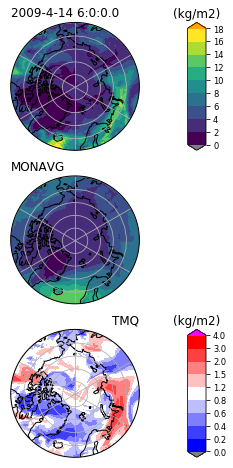

done with time 2009_04_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-13-21600.nc
figure being saved to  workdir/TMQ_2009_04_13h06_R.pdf
data range 0.34309378 19.781069
data range 0.8928696 14.075871
dtrng [0.         3.60254622]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.094805494 3.6025462


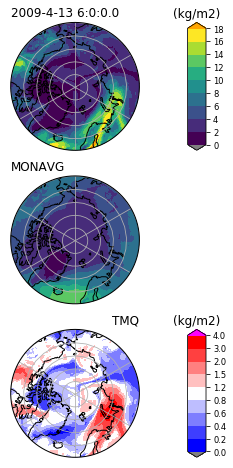

done with time 2009_04_13h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-17-21600.nc
figure being saved to  workdir/TMQ_2009_04_17h06_R.pdf
data range 0.19706161 18.628323
data range 0.8928696 14.075871
dtrng [0.         3.28420281]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16535208 3.2842028


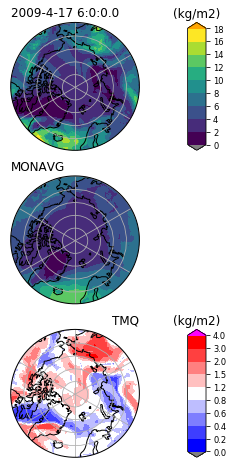

done with time 2009_04_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-08-21600.nc
figure being saved to  workdir/TMQ_2009_04_08h06_R.pdf
data range 0.37055582 18.49105
data range 0.8928696 14.075871
dtrng [0.         2.17916012]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.09506947 2.17916


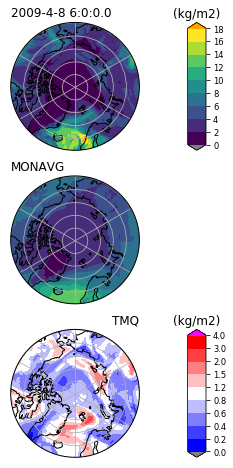

done with time 2009_04_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-11-21600.nc
figure being saved to  workdir/TMQ_2009_04_11h06_R.pdf
data range 0.4010247 24.236284
data range 0.8928696 14.075871
dtrng [0.         4.00460625]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20611139 4.0046062


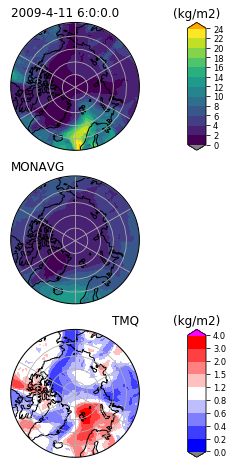

done with time 2009_04_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-03-21600.nc
figure being saved to  workdir/TMQ_2009_04_03h06_R.pdf
data range 0.43559232 25.75592
data range 0.8928696 14.075871
dtrng [0.         2.45918894]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.16781805 2.459189


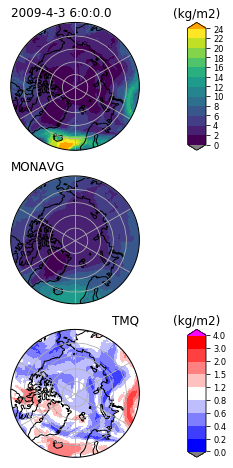

done with time 2009_04_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-22-21600.nc
figure being saved to  workdir/TMQ_2009_04_22h06_R.pdf
data range 0.7722015 21.872078
data range 0.8928696 14.075871
dtrng [0.         2.68795276]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.21197732 2.6879528


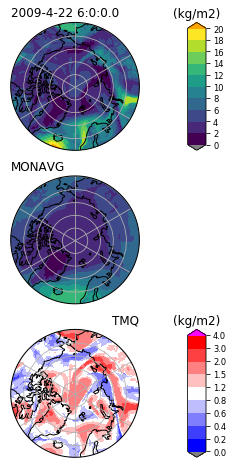

done with time 2009_04_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-09-21600.nc
figure being saved to  workdir/TMQ_2009_04_09h06_R.pdf
data range 0.28174523 21.392157
data range 0.8928696 14.075871
dtrng [0.         1.99155092]
dlevs1 [-0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20349556 1.9915509


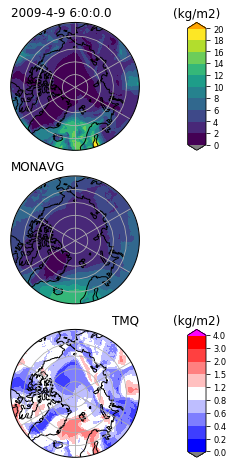

done with time 2009_04_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-05-21600.nc
figure being saved to  workdir/TMQ_2009_04_05h06_R.pdf
data range 0.3754548 18.634092
data range 0.8928696 14.075871
dtrng [0.         2.40844798]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.20147358 2.408448


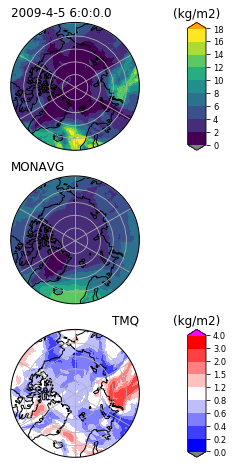

done with time 2009_04_05h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-16-21600.nc
figure being saved to  workdir/TMQ_2009_04_16h06_R.pdf
data range 0.2692507 19.328354
data range 0.8928696 14.075871
dtrng [0.         2.79256034]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.17621686 2.7925603


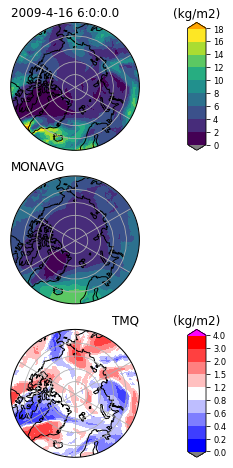

done with time 2009_04_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-07-21600.nc
figure being saved to  workdir/TMQ_2009_04_07h06_R.pdf
data range 0.3120426 18.134203
data range 0.8928696 14.075871
dtrng [0.         2.38988709]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.110311136 2.389887


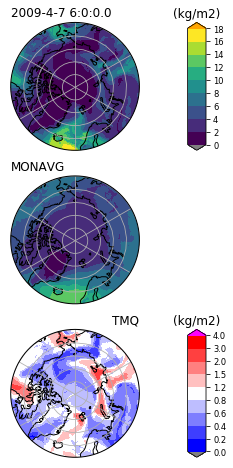

done with time 2009_04_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-21-21600.nc
figure being saved to  workdir/TMQ_2009_04_21h06_R.pdf
data range 0.76667917 21.189621
data range 0.8928696 14.075871
dtrng [0.         2.85614395]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.22927386 2.856144


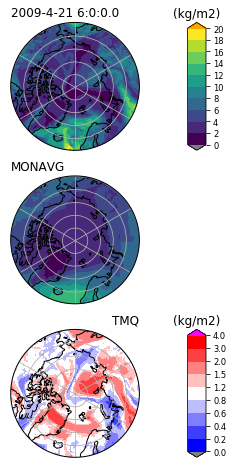

done with time 2009_04_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-12-21600.nc
figure being saved to  workdir/TMQ_2009_04_12h06_R.pdf
data range 0.23084 20.06685
data range 0.8928696 14.075871
dtrng [0.         4.04502821]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.1335602 4.045028


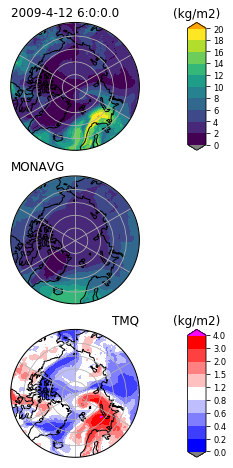

done with time 2009_04_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-23-21600.nc
figure being saved to  workdir/TMQ_2009_04_23h06_R.pdf
data range 0.65835184 23.460487
data range 0.8928696 14.075871
dtrng [0.         3.51822162]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.306236 3.5182216


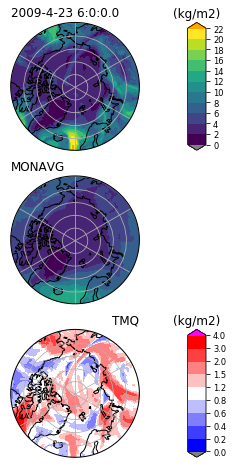

done with time 2009_04_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-28-21600.nc
figure being saved to  workdir/TMQ_2009_04_28h06_R.pdf
data range 0.78252304 26.814232
data range 0.8928696 14.075871
dtrng [0.         3.89434218]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.22290175 3.8943422


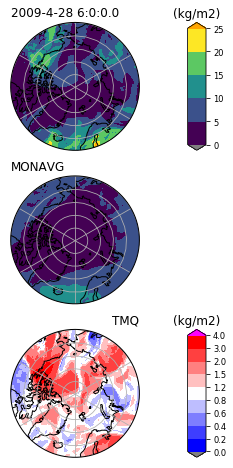

done with time 2009_04_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-27-21600.nc
figure being saved to  workdir/TMQ_2009_04_27h06_R.pdf
data range 0.5936354 23.570871
data range 0.8928696 14.075871
dtrng [0.         4.36781549]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.28405744 4.3678155


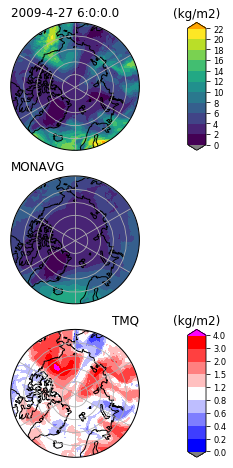

done with time 2009_04_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-30-21600.nc
figure being saved to  workdir/TMQ_2009_04_30h06_R.pdf
data range 1.0925759 25.165035
data range 0.8928696 14.075871
dtrng [0.         4.44400835]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.29025108 4.4440084


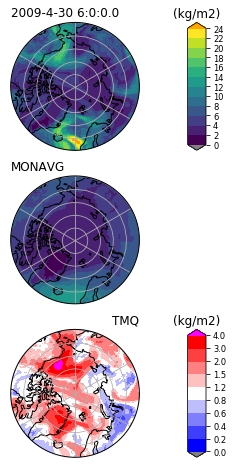

done with time 2009_04_30h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-20-21600.nc
figure being saved to  workdir/TMQ_2009_04_20h06_R.pdf
data range 0.4554645 18.138687
data range 0.8928696 14.075871
dtrng [0.         2.86208391]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.254308 2.862084


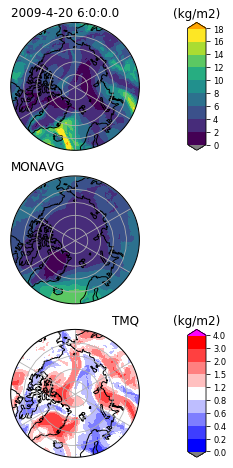

done with time 2009_04_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_04/atm/hist/yotc_f02_pdil_sat_04.cam.h1.2009-04-26-21600.nc
figure being saved to  workdir/TMQ_2009_04_26h06_R.pdf
data range 0.6284801 21.215664
data range 0.8928696 14.075871
dtrng [0.         3.33362007]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.5 2.  3.  4. ]
data range 0.3605126 3.33362


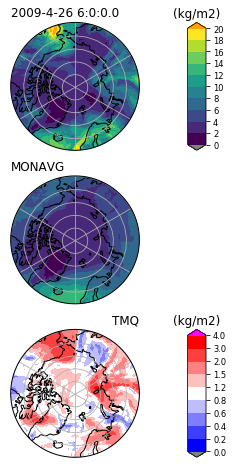

done with time 2009_04_26h06



all done


In [8]:
mon = "01"
monlist = np.array(["02","03","04"])
for mon in monlist:
    dir1, f1, dir2, files = setupfilenames(mon)

    plottype = "DIFF"
    plottype = "RATIO"
    dfact = 0.5  # multiplier on contour levels for anomalies
    dfact = 1.0  
    dfact = 0.5
    vname = "BURDEN2"
    vname = "TMQ"
    processtime (vname, dir1, f1, dir2, files)
print "all done"